# Setup & Components

In [ ]:
# load environment variables
from dotenv import load_dotenv
 
load_dotenv()

True

In [4]:
# fondation model
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google-genai")

c:\Users\Christian\Programming_Project\rag-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# embedding model
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [6]:
from langchain_chroma import Chroma

vector_store =  Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="../chroma_db"
)

# Indexing

## Loading Documents

In [7]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "../data/ai-engineering-book.pdf"
loader  = PyPDFLoader(file_path)

docs = loader.load()

In [18]:
docs[10]

Document(metadata={'producer': 'calibre 7.4.0', 'creator': 'calibre 7.4.0', 'creationdate': '2024-12-07T18:13:04+00:00', 'author': 'Chip Huyen', 'moddate': '2024-12-07T18:13:04+00:00', 'title': 'AI Engineering (for True Epub)', 'source': '../data/ai-engineering-book.pdf', 'total_pages': 991, 'page': 10, 'page_label': '11'}, page_content='I especially learned from early readers who tested my assumptions,\nintroduced me to different perspectives, and exposed me to new problems\nand approaches. Some sections of the book have also received thousands of\ncomments from the community after being shared on my blog, many giving\nme new perspectives or confirming a hypothesis.\nI hope that this learning process will continue for me now that the book is in\nyour hands, as you have experiences and perspectives that are unique to\nyou. Please feel free to share any feedback you might have for this book\nwith me via X, LinkedIn, or email at hi@huyenchip.com.')

In [19]:
print(docs[10].page_content)

I especially learned from early readers who tested my assumptions,
introduced me to different perspectives, and exposed me to new problems
and approaches. Some sections of the book have also received thousands of
comments from the community after being shared on my blog, many giving
me new perspectives or confirming a hypothesis.
I hope that this learning process will continue for me now that the book is in
your hands, as you have experiences and perspectives that are unique to
you. Please feel free to share any feedback you might have for this book
with me via X, LinkedIn, or email at hi@huyenchip.com.


## Splitting Documents

In [20]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 1640 sub-documents.


## Storing Document

In [21]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['8047d70e-5f18-45d6-bf89-0618bcba0ca1', 'aa99f2ef-1b95-4b02-8dcc-fbf60ed40eea', 'e87f17cf-2246-4255-b3ba-b4b775b49d6a']


# Retrieval & Generation

In [60]:
from langchain.prompts import ChatPromptTemplate

# Define your custom template
template = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:

"""

# Create a ChatPromptTemplate
prompt = ChatPromptTemplate.from_template(template)

# Example usage
example_messages = prompt.invoke(
    {"context": "I am cool", "question": "Where is the Eiffel Tower located?"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)



You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: Where is the Eiffel Tower located? 
Context: I am cool 
Answer:




In [61]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [62]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


In [63]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [64]:
result = graph.invoke({"question": "What is entrophy?"})

print(f"Context: {result["context"]}\n\n")
print(f"Answer: {result["answer"]}")

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 44.769214598s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 44
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<lo

Context: [Document(id='667a9711-30a5-4486-b718-fe194846c2b3', metadata={'author': 'Chip Huyen', 'creationdate': '2024-12-07T18:13:04+00:00', 'moddate': '2024-12-07T18:13:04+00:00', 'page_label': '242', 'title': 'AI Engineering (for True Epub)', 'total_pages': 991, 'page': 241, 'producer': 'calibre 7.4.0', 'creator': 'calibre 7.4.0', 'source': '../data/ai-engineering-book.pdf'}, page_content='on your production data. In general, the closer your data is to a model’s\ntraining data, the better the model can perform on your data.\nCompared to the rest of the book, this section is math-heavy. If you find it\nconfusing, feel free to skip the math part and focus on the discussion of how\nto interpret these metrics. Even if you’re not training or finetuning language\nmodels, understanding these metrics can help with evaluating which models\nto use for your application. These metrics can occasionally be used for\ncertain evaluation and data deduplication techniques, as discussed\nthroughout thi

In [65]:
for step in graph.stream(
    {"question": "What is entrophy?"}, stream_mode="updates"
):
    print(f"{step}\n\n-------------------\n")

{'retrieve': {'context': [Document(id='667a9711-30a5-4486-b718-fe194846c2b3', metadata={'creator': 'calibre 7.4.0', 'source': '../data/ai-engineering-book.pdf', 'creationdate': '2024-12-07T18:13:04+00:00', 'title': 'AI Engineering (for True Epub)', 'author': 'Chip Huyen', 'page_label': '242', 'page': 241, 'moddate': '2024-12-07T18:13:04+00:00', 'total_pages': 991, 'producer': 'calibre 7.4.0'}, page_content='on your production data. In general, the closer your data is to a model’s\ntraining data, the better the model can perform on your data.\nCompared to the rest of the book, this section is math-heavy. If you find it\nconfusing, feel free to skip the math part and focus on the discussion of how\nto interpret these metrics. Even if you’re not training or finetuning language\nmodels, understanding these metrics can help with evaluating which models\nto use for your application. These metrics can occasionally be used for\ncertain evaluation and data deduplication techniques, as discussed

KeyboardInterrupt: 

# Chains

In [ ]:
from langgraph.graph import MessagesState, StateGraph 

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_response(state: MessagesState):
    """Generate tool call for retrieval or respond"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state['messages'])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer"""
    # Get generated ToolMessages
    recent_tool_messages = []
    for  message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format intro prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question answering task. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )

    conversation_messages = [
        message
        for message in state['messages']
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    prompt = [SystemMessage(system_message_content)] + conversation_messages

    #  Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_response)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_response")
graph_builder.add_conditional_edges(
    "query_or_response",
    tools_condition,
    {END: END, "tools": "tools"}
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

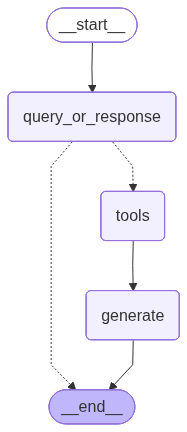

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_messages = "hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_messages}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [ ]:
input_messages = "Waht is enthropy?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_messages}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Waht is enthropy?
================================== Ai Message ==================================
Tool Calls:
  retrieve (5a8282b9-56dd-45de-85b4-326af4131f52)
 Call ID: 5a8282b9-56dd-45de-85b4-326af4131f52
  Args:
    query: entropy
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'calibre 7.4.0', 'creationdate': '2024-12-07T18:13:04+00:00', 'title': 'AI Engineering (for True Epub)', 'author': 'Chip Huyen', 'total_pages': 991, 'page_label': '243', 'moddate': '2024-12-07T18:13:04+00:00', 'page': 242, 'creator': 'calibre 7.4.0', 'source': '../data/ai-engineering-book.pdf'}
Content: Figure 3-4. Two languages describe positions within a square. Compared to the language on the left
(a), the tokens on the right (b) carry more information, but they need more bits to represent them.
If your language has four tokens, shown as (b) in Figure 3-4,

In [51]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [53]:
input_messages = "What is enthropy?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_messages}]},
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is enthropy?
================================== Ai Message ==================================
Tool Calls:
  retrieve (97fcc165-8d56-485d-a41f-381834c16590)
 Call ID: 97fcc165-8d56-485d-a41f-381834c16590
  Args:
    query: entropy
================================= Tool Message =================================
Name: retrieve

Source: {'creator': 'calibre 7.4.0', 'page': 242, 'moddate': '2024-12-07T18:13:04+00:00', 'author': 'Chip Huyen', 'title': 'AI Engineering (for True Epub)', 'producer': 'calibre 7.4.0', 'total_pages': 991, 'source': '../data/ai-engineering-book.pdf', 'creationdate': '2024-12-07T18:13:04+00:00', 'page_label': '243'}
Content: Figure 3-4. Two languages describe positions within a square. Compared to the language on the left
(a), the tokens on the right (b) carry more information, but they need more bits to represent them.
If your language has four tokens, shown as (b) in Figure 3-4,

In [54]:
input_message = "Is there any kind of things that similar to it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Is there any kind of things that similar to it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (bdc289de-7f3d-4f8a-8eb0-a6785a307288)
 Call ID: bdc289de-7f3d-4f8a-8eb0-a6785a307288
  Args:
    query: information content unpredictability bits information representation
================================= Tool Message =================================
Name: retrieve

Source: {'moddate': '2024-12-07T18:13:04+00:00', 'creator': 'calibre 7.4.0', 'author': 'Chip Huyen', 'total_pages': 991, 'creationdate': '2024-12-07T18:13:04+00:00', 'title': 'AI Engineering (for True Epub)', 'page': 241, 'page_label': '242', 'source': '../data/ai-engineering-book.pdf', 'producer': 'calibre 7.4.0'}
Content: bits are needed to represent a token.
Let’s use a simple example to illustrate this. Imagine you want to create a
language to describe positions within a square, as show

In [55]:
input_message = "Can you give others term beside enthropy that I need to know?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you give others term beside enthropy that I need to know?
================================== Ai Message ==================================
Tool Calls:
  retrieve (489f69b3-8fc3-4061-8ef7-b6ade23791b0)
 Call ID: 489f69b3-8fc3-4061-8ef7-b6ade23791b0
  Args:
    query: information theory terms AI engineering
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'Chip Huyen', 'creator': 'calibre 7.4.0', 'producer': 'calibre 7.4.0', 'moddate': '2024-12-07T18:13:04+00:00', 'page_label': '115', 'source': '../data/ai-engineering-book.pdf', 'title': 'AI Engineering (for True Epub)', 'total_pages': 991, 'page': 114, 'creationdate': '2024-12-07T18:13:04+00:00'}
Content: AI engineering. However, AI engineering also brings with it new challenges
and solutions. The last section of the chapter discusses the AI engineering
stack, including how it has chang

# Agent

In [56]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

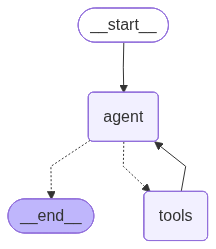

In [57]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [66]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is RAG?\n\n"
    "Once you get the answer, look up how to create that."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 52.858098947s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 52
}
].


================================ Human Message =================================

What is RAG?

Once you get the answer, look up how to create that.


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 50.768515567s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 50
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<lo

================================== Ai Message ==================================
Tool Calls:
  retrieve (1bf1fff8-dedf-4b52-b7be-016cef12a96a)
 Call ID: 1bf1fff8-dedf-4b52-b7be-016cef12a96a
  Args:
    query: What is RAG?
================================= Tool Message =================================
Name: retrieve

Source: {'creator': 'calibre 7.4.0', 'producer': 'calibre 7.4.0', 'title': 'AI Engineering (for True Epub)', 'author': 'Chip Huyen', 'total_pages': 991, 'page_label': '498', 'page': 497, 'source': '../data/ai-engineering-book.pdf', 'moddate': '2024-12-07T18:13:04+00:00', 'creationdate': '2024-12-07T18:13:04+00:00'}
Content: RAG Architecture
A RAG system has two components: a retriever that retrieves information
from external memory sources and a generator that generates a response
based on the retrieved information. Figure 6-2 shows a high-level
architecture of a RAG system.

Source: {'page': 498, 'moddate': '2024-12-07T18:13:04+00:00', 'title': 'AI Engineering (for True E